In [1]:
from os import getcwd, path
import sys
import matplotlib.pyplot as plt

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

from entities_recognition.bilstm.train import trainIters, evaluate_all
from config import START_TAG, STOP_TAG

In [2]:
TRAIN_PATH = path.join(BASE_PATH, 'data/CoNLL-2003/eng.train')
print(TRAIN_PATH)

/Users/2359media/Documents/botbot-nlp/data/CoNLL-2003/eng.train


In [3]:
import io
import string

def ident(x):
    return x

def read_conll_2003(filename):
    all_data = []

    current_txt = []
    current_tags = []
    tagset = []

    fin = io.open(filename, 'r', encoding='utf-8', newline='\n', errors='ignore')
    for line in fin:
        line = line.strip()
        if len(line) > 0: # skip blank lines
            tmp = line.split(' ')
            if tmp[0] != '-DOCSTART-':
                current_txt.append(tmp[0])
                current_tags.append(tmp[-1])
                tagset.append(tmp[-1])
        else:
            if len(current_txt) > 0:
                all_data.append((current_txt, ' '.join(current_tags)))
                current_txt = []
                current_tags = []
    fin.close()

    tagset = list(set(tagset))
    tag_to_ix = {tag: key for key, tag in enumerate(tagset)}
    tag_to_ix[START_TAG] = len(tagset)
    tag_to_ix[STOP_TAG] = len(tagset) + 1

    print(tag_to_ix)
    print('Loaded %s sentences' % len(all_data))
    
    return tag_to_ix, all_data

In [4]:
from entities_recognition.bilstm.predict import read_tags

tag_to_ix, training_data = read_conll_2003(TRAIN_PATH)
result = []
for sentence, tag_seq in training_data:
    assert len(sentence) == len(tag_seq.split(' '))
#     print(read_tags(tokens_in, tag_seq.split(' ')))

{'I-ORG': 0, 'I-MISC': 1, 'I-PER': 2, 'B-MISC': 3, 'I-LOC': 4, 'B-LOC': 5, 'O': 6, 'B-ORG': 7, '<START>': 8, '<STOP>': 9}
Loaded 14041 sentences


Importing /Users/2359media/Documents/botbot-nlp/data/fasttext/crawl-300d-2M.vec...
449m 15s (- 8535m 59s) (1 5%) 30086.9609
513m 4s (- 4617m 43s) (2 10%) 19621.0898
595m 9s (- 3372m 34s) (3 15%) 16367.3008
651m 49s (- 2607m 18s) (4 20%) 13931.5166
706m 34s (- 2119m 42s) (5 25%) 12314.6416
761m 33s (- 1776m 58s) (6 30%) 10746.4297
816m 24s (- 1516m 12s) (7 35%) 9764.7168
871m 23s (- 1307m 5s) (8 40%) 8829.0264
926m 51s (- 1132m 49s) (9 45%) 8116.2432
1096m 12s (- 1096m 12s) (10 50%) 7225.4370
1154m 3s (- 944m 14s) (11 55%) 6815.1177
1213m 30s (- 809m 0s) (12 60%) 6292.7051
1278m 8s (- 688m 14s) (13 65%) 5750.0151
1348m 7s (- 577m 45s) (14 70%) 5572.3145
1418m 1s (- 472m 40s) (15 75%) 5047.6250
1480m 25s (- 370m 6s) (16 80%) 4789.4028
1544m 53s (- 272m 37s) (17 85%) 4480.5605
1615m 45s (- 179m 31s) (18 90%) 4151.5063
1682m 20s (- 88m 32s) (19 95%) 4062.3723
1868m 56s (- 0m 0s) (20 100%) 3856.7993


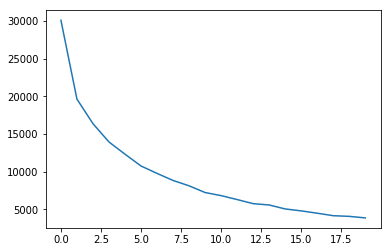

In [5]:
losses, model = trainIters(training_data, 
                           tag_to_ix,
                           learning_rate=1e-3,
                           n_iters=20, 
                           log_every=1,
                           tokenizer=ident,
                           verbose=1)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
fig, ax = plt.subplots()
plt.plot(losses)

In [6]:
import torch
model.eval()
torch.save(model.state_dict(), 'bilstm-rnn-conll2003-vanilla.bin')

Model recall

In [7]:
evaluate_all(model, training_data, tag_to_ix, tokenizer=ident)

0.9923436187819528

In [8]:
TEST_PATH_A = path.join(BASE_PATH, 'data/CoNLL-2003/eng.testa')
TEST_PATH_B = path.join(BASE_PATH, 'data/CoNLL-2003/eng.testb')
_, testing_data_a = read_conll_2003(TEST_PATH_A)
_, testing_data_b = read_conll_2003(TEST_PATH_B)

{'I-ORG': 0, 'I-MISC': 1, 'I-PER': 2, 'B-MISC': 3, 'I-LOC': 4, 'O': 5, '<START>': 6, '<STOP>': 7}
Loaded 3250 sentences
{'I-ORG': 0, 'I-PER': 1, 'I-MISC': 2, 'B-MISC': 3, 'I-LOC': 4, 'B-LOC': 5, 'O': 6, 'B-ORG': 7, '<START>': 8, '<STOP>': 9}
Loaded 3453 sentences


Accuracy on test sets

In [9]:
evaluate_all(model, testing_data_a, tag_to_ix, tokenizer=ident)

0.9775709668626611

In [10]:
evaluate_all(model, testing_data_b, tag_to_ix, tokenizer=ident)

0.9630020458705718

In [11]:
from entities_recognition.bilstm.predict import predict
from common.utils import wordpunct_tokenize

test_data = [
    'I live in Ho Chi Minh City, nice place, though my hometown is in Hanoi. I do miss it sometimes',
    'Trump’s role in midterm elections roils Republicans',
    'Kenya bans film about 2 girls in love because it’s ‘too hopeful’',
    'G.O.P. leaders and White House aides are trying to prepare President Trump for trouble in House and Senate races.'
]
predict(model, test_data, tag_to_ix, tokenizer=wordpunct_tokenize, delimiter=' ')

Raw predicted tags:
[6, 6, 6, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6]
[6, 6, 6, 6, 6, 6, 6, 6, 1]
[4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[6, 6, 0, 6, 6, 6, 6, 6, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 0, 6, 6]


[{'LOC': ['Ho Chi Minh City', 'Hanoi']},
 {'MISC': ['Republicans']},
 {'LOC': ['Kenya']},
 {'LOC': ['White House', 'House'], 'ORG': ['O', 'Senate']}]

In [12]:
import json
with open('tag_to_ix.json', 'w') as tagfile:
    json.dump(tag_to_ix, tagfile)

`./conlleval < testa.out.txt`
```
processed 51578 tokens with 5942 phrases; found: 5964 phrases; correct: 5167.
accuracy:  97.77%; precision:  86.64%; recall:  86.96%; FB1:  86.80
              LOC: precision:  86.50%; recall:  93.85%; FB1:  90.03  1993
             MISC: precision:  88.84%; recall:  81.13%; FB1:  84.81  842
              ORG: precision:  81.34%; recall:  78.67%; FB1:  79.98  1297
              PER: precision:  89.52%; recall:  89.03%; FB1:  89.28  1832
```
`./conlleval < testb.out.txt`
```
processed 46666 tokens with 5879 phrases; found: 5674 phrases; correct: 4586.
accuracy:  95.79%; precision:  80.82%; recall:  78.01%; FB1:  79.39
              LOC: precision:  82.29%; recall:  89.15%; FB1:  85.58  1807
             MISC: precision:  77.29%; recall:  72.22%; FB1:  74.67  656
              ORG: precision:  75.56%; recall:  75.74%; FB1:  75.65  1665
              PER: precision:  86.29%; recall:  82.50%; FB1:  84.35  1546
```